In [2]:
import networkx as nx
import random
import future
import numpy as np
from math import comb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import decimal
import hvplot.pandas
import panel as pn; pn.extension()
from panel.template import DarkTheme
decimal.getcontext().prec = 50  # 设置计算精度，防止计算溢出
class network_simulation:
    def __init__(self,order,rational_rate,imitation_rate,beta,
                 tax_coefficient,
                 subsidy_coefficient,iteration_times,initial_rate,k,n):
        self.G=nx.barabasi_albert_graph(200,n,seed=10)
        self.G.protection={node:[0.00] for node in self.G.nodes}
        self.n=n
        self.actual_iteration=0
        self.order=order
        self.k=k
        self.initial_rate=initial_rate
        self.iteration_times=iteration_times     
        self.rational_rate=rational_rate
        self.imitation_rate=imitation_rate
        self.beta=beta
        self.tax_coefficient=tax_coefficient
        self.subsidy_coefficient=subsidy_coefficient
        self.enterprise_nodes = np.array(list(self.G.nodes), ndmin=1) 
        self.enterprise_edges = np.array(self.G.edges, ndmin=2) 
        ###
        self.total_imitations = []
    def find_neighbor(self,agent, edges_list):
        agent_neighbor = []
        for a in range(len(edges_list)):
            if edges_list[a][0] == agent:
                agent_neighbor.append(edges_list[a][1])
            elif edges_list[a][1] == agent:
                agent_neighbor.append(edges_list[a][0])
            else:
                pass
        return agent_neighbor
    def complexes_protection(self,node):
        order=self.order
        T=self.actual_iteration
        neighbors=list(self.G.neighbors(node))
        protect_influence=[self.G.protection[i][T] for i in neighbors]
        total=len(neighbors)
        vertices=[i for i in range(1,order+1)]
        complexes=[]
        comp_co=[]
        comp_l=[]
        while len(neighbors)>0:
            if len(neighbors)>=order:
                num_vertice=random.choice(vertices)
            else:
                num_vertice=random.choice(range(1,len(neighbors)+1))
            nodes=random.sample(neighbors,k=num_vertice)
            neighbors=list(set(neighbors)-set(nodes))
            complexes.append(nodes)
            comp_l.append(len(nodes))#表示i单纯形的数量，下面“/”表示占所有单纯形的比例
        comp_co=[((1+comp_l.count(i)/len(comp_l))**(comb(i+1,3))) for i in comp_l] #表示i单纯形的强化作用
        for ind in range(len(complexes)):
            comp=complexes[ind]
            coefficient=comp_co[ind]
            complex_effectness=[]
            if coefficient>1:
                for node in comp:
                    complex_effectness.append(self.G.protection[node][-1])#complex_effectness 取决于单纯形中的节点的保护值，-1表示最新的保护值
                protect_influence.append(np.mean(complex_effectness)*coefficient)
        final_protection=sum(protect_influence)/total
        return final_protection
    def calculate_values(self, node_i, A, A11, A12, A21, A22, B, B11, B12, B21, B22):
        imitation = self.imitation_rate * self.complexes_protection(node_i)
        if len(self.total_imitations) < self.iteration_times:
            self.total_imitations.append(imitation)
        else:
            self.total_imitations[self.actual_iteration] += imitation
        pi_0_t = self.beta * (B * B11 + (1 - B) * B21) + (1 - self.beta) * (B * B12 + (1 - B) * B22)-imitation
        pi_1_t = self.beta * (A * A11 + (1 - A) * A21) + (1 - self.beta) * (A * A12 + (1 - A) * A22)+imitation
        
        return imitation, pi_0_t, pi_1_t
    
    def self_protection(self, node_i, A, A11, A12, A21, A22, B, B11, B12, B21, B22):
        _, pi_0_t, pi_1_t = self.calculate_values(node_i, A, A11, A12, A21, A22, B, B11, B12, B21, B22)
        def sigmoid(x, r):
            z = np.exp(-r * x)
            sig = (2 / (1 + z)) - 1
            return sig
        d = pi_1_t - pi_0_t
        return sigmoid(d, self.rational_rate)
    
    def green_payoff(self, node_i, A, A11, A12, A21, A22, B, B11, B12, B21, B22):
        _, _, pi_1_t = self.calculate_values(node_i, A, A11, A12, A21, A22, B, B11, B12, B21, B22)
        return pi_1_t
    def nongreen_payoff(self, node_i, A, A11, A12, A21, A22, B, B11, B12, B21, B22):
        _, pi_0_t, _ = self.calculate_values(node_i, A, A11, A12, A21, A22, B, B11, B12, B21, B22)
        return pi_0_t

    def run(self):
        enterprise_strategy_t0=[]
        self.cumulative_payoff = [[] for _ in range(len(self.enterprise_nodes))]  # 初始化累积收益
        for i in range(len(self.enterprise_nodes)):
            if np.random.rand(1)<=self.initial_rate:
                enterprise_strategy_t0.append((1,0))
            else:
                enterprise_strategy_t0.append((0,1))
        enterprise_strategy=enterprise_strategy_t0[:]
        t=[]
        t0=[]
        green_num_changelog=[0 for item in range(self.iteration_times)]
        for i in range(self.iteration_times):
            self.actual_iteration=i
            t.append(i)
            t0.append(i+1)
            green_num=0
            for e in range(len(self.enterprise_nodes)):
                if enterprise_strategy[e]==(1,0):
                    green_num=green_num+1
                else:
                    pass
            green_num_changelog[i]=green_num_changelog[i]+green_num
            payoff=[]
            for e in range(len(self.enterprise_nodes)):
                e_neighbor = self.find_neighbor(e+1,self.enterprise_edges)
                e_neighbor_num=len(e_neighbor)
                e_green_neighbor_num=0
                e_nongreen_neighbor_num=0
                e_payoff=0
                for l in range(len(e_neighbor)):
                    if enterprise_strategy[e_neighbor[l] - 1] == (1,0):
                        e_green_neighbor_num = e_green_neighbor_num + 1
                    else:
                        e_nongreen_neighbor_num = e_nongreen_neighbor_num + 1
                A=(e_green_neighbor_num+1)/(e_neighbor_num+1)
                B=(e_nongreen_neighbor_num+1)/(e_neighbor_num+1)
                A11=9-self.tax_coefficient*3+self.subsidy_coefficient*2-2
                A12=self.subsidy_coefficient*2-2-self.tax_coefficient*3
                A21=(9-self.tax_coefficient*3)+self.subsidy_coefficient*2-2
                A22=self.subsidy_coefficient*2-2-self.tax_coefficient*3
                B11=0-self.tax_coefficient*6
                B12=(6-self.tax_coefficient*6)
                B21=0-self.tax_coefficient*6
                B22=6-self.tax_coefficient*6
                protection=self.self_protection(e,A,A11,A12,A21,A22,B,B11,B12,B21,B22)
                self.G.protection[e].append(protection)
                if enterprise_strategy[e]==(1,0):
                    e_payoff=self.green_payoff(e,A,A11,A12,A21,A22,B,B11,B12,B21,B22)
                else:
                    e_payoff=self.nongreen_payoff(e,A,A11,A12,A21,A22,B,B11,B12,B21,B22)
                payoff.append(e_payoff)
                self.cumulative_payoff[e].append(e_payoff)  # 更新累积收益

            for j in range(len(self.enterprise_nodes)):
                # 计算节点j的邻居的策略参数
                j_neighbor = self.find_neighbor(j+1,self.enterprise_edges)
                j_neighbor_payoff=[]
                for a in range(len(j_neighbor)):
                    neighbor=j_neighbor[a]
                    neighbor_payoff=payoff[neighbor-1]
                    j_neighbor_payoff.append(neighbor_payoff)
                total_payoff=np.sum(payoff)
                j_neighbor_prob=[payoff_item/total_payoff for payoff_item in j_neighbor_payoff]
                choose_prob=0
                k1=0
                choose_neighbor=0
                l1=np.random.rand(1)
                while choose_prob<=l1:
                    if k1==len(j_neighbor_prob):
                        break
                    choose_neighbor=j_neighbor[k1]
                    choose_prob += j_neighbor_prob[k1]
                    k1+=1
                if enterprise_strategy[j]==enterprise_strategy[choose_neighbor-1]:
                    pass
                else:
                    ###
                    j_degree=len(j_neighbor)
                    choose_neighbor_degree=len(self.find_neighbor(choose_neighbor,self.enterprise_edges))
                    j_payoff=np.sum(self.cumulative_payoff[j])/j_degree  # 使用累积收益
                    choose_neighbor_payoff=np.sum(self.cumulative_payoff[choose_neighbor-1])/choose_neighbor_degree  # 使用累积收益
                    ecp=(j_payoff-choose_neighbor_payoff)/self.k
                    ecp=np.sum(ecp)
                    change_prob=1/(1+decimal.Decimal(math.e)**decimal.Decimal(ecp))
                    m=np.random.rand(1)
                    if m<=change_prob:
                        enterprise_strategy[j]=enterprise_strategy[choose_neighbor-1]
                    else:
                        pass   
        green_num_changelog=[item for item in green_num_changelog]
        self.green_num_changelog=green_num_changelog
        self.total_imitations = [total / 200 for total in self.total_imitations]

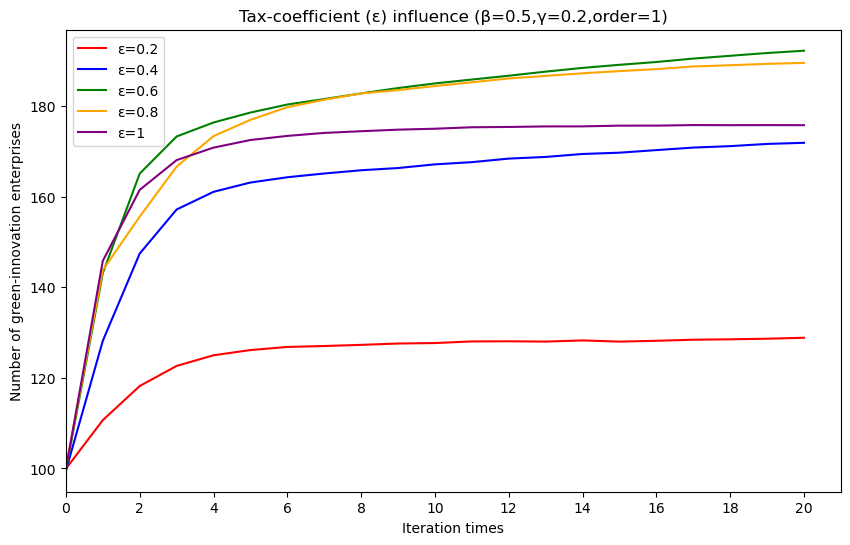

[ 99.94  110.675 118.205 122.645 125.    126.15  126.835 127.045 127.295
 127.595 127.7   128.055 128.085 128.02  128.28  128.015 128.195 128.435
 128.525 128.655 128.865]
[ 99.505 128.2   147.46  157.19  161.095 163.145 164.31  165.14  165.855
 166.345 167.155 167.645 168.43  168.795 169.45  169.735 170.305 170.86
 171.18  171.67  171.915]
[ 99.61  143.14  165.12  173.31  176.4   178.595 180.37  181.575 182.82
 184.005 185.03  185.885 186.73  187.63  188.46  189.14  189.76  190.515
 191.13  191.745 192.25 ]
[100.185 143.805 155.615 166.66  173.395 176.98  179.78  181.425 182.815
 183.555 184.45  185.285 186.125 186.685 187.27  187.75  188.19  188.775
 189.045 189.35  189.56 ]
[ 99.845 145.845 161.525 168.095 170.85  172.535 173.44  174.1   174.475
 174.82  175.025 175.35  175.415 175.535 175.545 175.705 175.71  175.83
 175.81  175.825 175.81 ]


In [3]:
def run_simulation(run_times:int,rational_rate=9,iteration_times=5,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.1):
    results=[]
    for h in range(run_times):
        simulation=network_simulation(rational_rate=rational_rate,iteration_times=iteration_times,initial_rate=initial_rate,
                                        order=order,imitation_rate=imitation_rate,n=n,beta=beta,k=k,
                                        tax_coefficient=tax_coefficient,subsidy_coefficient=subsidy_coefficient)
        simulation.run()
        results.append(simulation.green_num_changelog)
        #if h<2:
        #    print(f"Result of run {h+1}:{simulation.green_num_changelog}")
        #elif h==2:
        #    print("...")
    return np.mean(results,axis=0)

simulation1 = run_simulation(200,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.2)
simulation2 = run_simulation(200,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.4,subsidy_coefficient=0.2)
simulation3 = run_simulation(200,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.6,subsidy_coefficient=0.2)
simulation4 = run_simulation(200,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.8,subsidy_coefficient=0.2)
simulation5 = run_simulation(200,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=1,subsidy_coefficient=0.2)

params = [
    [simulation1,'ε=0.2','red','-'],
    [simulation2,'ε=0.4','blue','-'],
    [simulation3,'ε=0.6','green','-'],
    [simulation4,'ε=0.8','orange','-'],
    [simulation5,'ε=1','purple','-'],


]
def plot(params):
    fig, ax = plt.subplots(figsize=(10, 6))
    for param in params:
        ax.plot(param[0], label=param[1],color=param[2],linestyle=param[3])
    ax.set_xlabel('Iteration times')
    ax.set_ylabel('Number of green-innovation enterprises')
    ax.set_title('Tax-coefficient (ε) influence (β=0.5,γ=0.2,order=1)')
    ax.legend()
    plt.xticks(np.arange(0, 21, 2))
    plt.xlim(0, 21)
    plt.show()
plot(params)
print(simulation1)
print(simulation2)
print(simulation3)
print(simulation4)
print(simulation5)
#plt.savefig("3.7_1.png",dpi=1200)

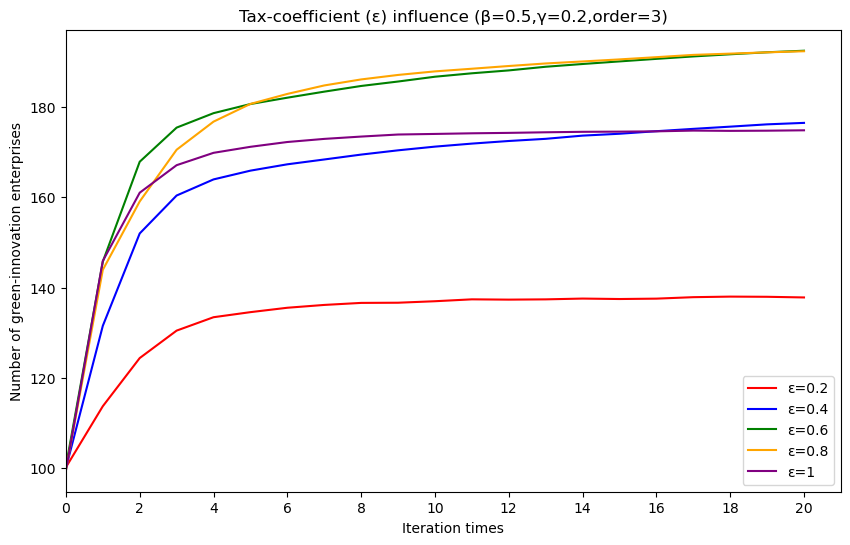

[100.13  113.675 124.355 130.44  133.41  134.535 135.51  136.135 136.585
 136.625 136.955 137.375 137.31  137.37  137.545 137.445 137.53  137.855
 137.98  137.94  137.795]
[ 99.93  131.5   151.985 160.395 163.965 165.91  167.315 168.385 169.47
 170.415 171.235 171.905 172.485 172.965 173.675 174.09  174.655 175.175
 175.665 176.175 176.5  ]
[100.31  145.73  167.885 175.45  178.655 180.68  182.085 183.425 184.685
 185.67  186.735 187.495 188.135 188.945 189.555 190.13  190.695 191.235
 191.71  192.155 192.5  ]
[ 99.49  143.915 159.08  170.545 176.775 180.705 182.92  184.8   186.135
 187.13  187.92  188.505 189.11  189.675 190.12  190.575 191.07  191.575
 191.855 192.14  192.385]
[ 99.375 145.89  161.02  167.12  169.86  171.195 172.26  172.95  173.465
 173.92  174.05  174.19  174.285 174.415 174.52  174.56  174.625 174.79
 174.73  174.77  174.855]


In [4]:
def run_simulation(run_times:int,rational_rate=9,iteration_times=5,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.1):
    results=[]
    for h in range(run_times):
        simulation=network_simulation(rational_rate=rational_rate,iteration_times=iteration_times,initial_rate=initial_rate,
                                        order=order,imitation_rate=imitation_rate,n=n,beta=beta,k=k,
                                        tax_coefficient=tax_coefficient,subsidy_coefficient=subsidy_coefficient)
        simulation.run()
        results.append(simulation.green_num_changelog)
        #if h<2:
        #    print(f"Result of run {h+1}:{simulation.green_num_changelog}")
        #elif h==2:
        #    print("...")
    return np.mean(results,axis=0)

simulation1 = run_simulation(200,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=3,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.2)
simulation2 = run_simulation(200,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=3,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.4,subsidy_coefficient=0.2)
simulation3 = run_simulation(200,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=3,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.6,subsidy_coefficient=0.2)
simulation4 = run_simulation(200,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=3,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.8,subsidy_coefficient=0.2)
simulation5 = run_simulation(200,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=3,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=1,subsidy_coefficient=0.2)

params = [
    [simulation1,'ε=0.2','red','-'],
    [simulation2,'ε=0.4','blue','-'],
    [simulation3,'ε=0.6','green','-'],
    [simulation4,'ε=0.8','orange','-'],
    [simulation5,'ε=1','purple','-'],


]
def plot(params):
    fig, ax = plt.subplots(figsize=(10, 6))
    for param in params:
        ax.plot(param[0], label=param[1],color=param[2],linestyle=param[3])
    ax.set_xlabel('Iteration times')
    ax.set_ylabel('Number of green-innovation enterprises')
    ax.set_title('Tax-coefficient (ε) influence (β=0.5,γ=0.2,order=3)') 
    ax.legend()
    plt.xticks(np.arange(0, 21, 2))
    plt.xlim(0, 21)
    plt.show()
plot(params)
print(simulation1)
print(simulation2)
print(simulation3)
print(simulation4)
print(simulation5)
#plt.savefig("3.7_1.png",dpi=1200)

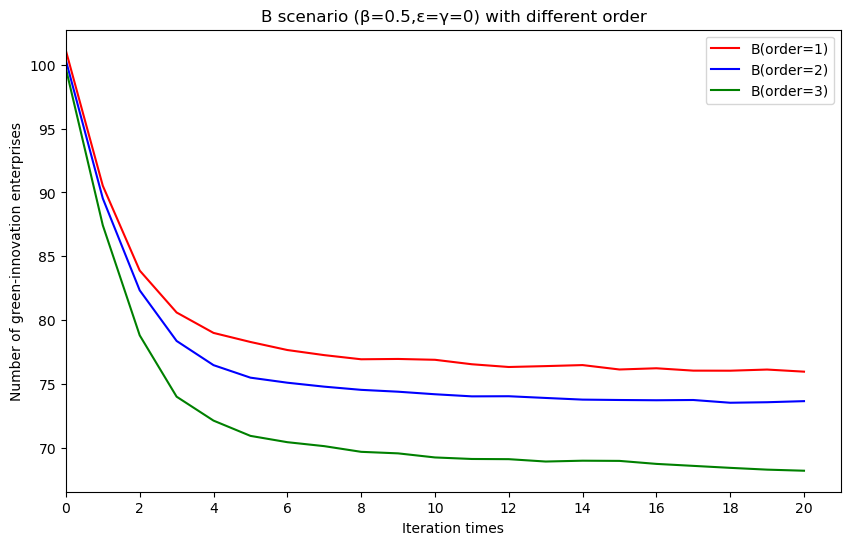

[101.105  90.525  83.885  80.6    79.     78.29   77.66   77.26   76.935
  76.96   76.895  76.545  76.33   76.4    76.48   76.135  76.23   76.045
  76.04   76.13   75.965]
[100.34   89.535  82.335  78.37   76.475  75.495  75.1    74.79   74.54
  74.395  74.195  74.03   74.04   73.905  73.775  73.745  73.725  73.745
  73.53   73.57   73.655]
[99.705 87.43  78.81  74.005 72.13  70.935 70.44  70.13  69.685 69.565
 69.245 69.125 69.11  68.925 68.99  68.975 68.74  68.585 68.43  68.29
 68.205]


In [5]:
def run_simulation(run_times:int,rational_rate=9,iteration_times=5,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.1):
    results=[]
    for h in range(run_times):
        simulation=network_simulation(rational_rate=rational_rate,iteration_times=iteration_times,initial_rate=initial_rate,
                                        order=order,imitation_rate=imitation_rate,n=n,beta=beta,k=k,
                                        tax_coefficient=tax_coefficient,subsidy_coefficient=subsidy_coefficient)
        simulation.run()
        results.append(simulation.green_num_changelog)
        #if h<2:
        #    print(f"Result of run {h+1}:{simulation.green_num_changelog}")
        #elif h==2:
        #    print("...")
    return np.mean(results,axis=0)

simulation1 = run_simulation(200,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0,subsidy_coefficient=0)
simulation2 = run_simulation(200,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=2,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0,subsidy_coefficient=0)
simulation3 = run_simulation(200,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=3,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0,subsidy_coefficient=0)

params = [
    [simulation1,'B(order=1)','red','-'],
    [simulation2,'B(order=2)','blue','-'],
    [simulation3,'B(order=3)','green','-'],


]
def plot(params):
    fig, ax = plt.subplots(figsize=(10, 6))
    for param in params:
        ax.plot(param[0], label=param[1],color=param[2],linestyle=param[3])
    ax.set_xlabel('Iteration times')
    ax.set_ylabel('Number of green-innovation enterprises')
    ax.set_title('B scenario (β=0.5,ε=γ=0) with different order') 
    ax.legend()
    plt.xticks(np.arange(0, 21, 2))
    plt.xlim(0, 21)
    plt.show()
plot(params)
print(simulation1)
print(simulation2)
print(simulation3)

#plt.savefig("3.7_1.png",dpi=1200)

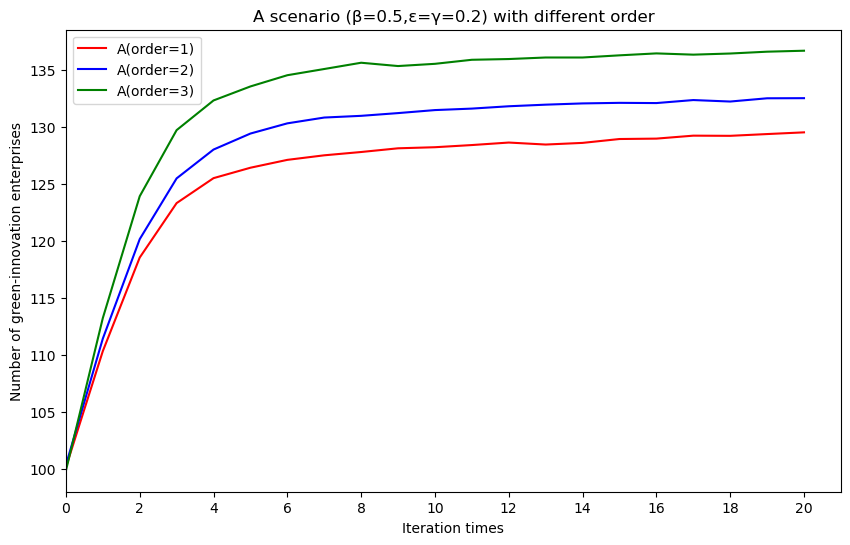

[100.15  110.35  118.565 123.345 125.535 126.45  127.14  127.54  127.83
 128.155 128.25  128.44  128.66  128.485 128.63  128.97  129.005 129.265
 129.25  129.405 129.555]
[100.35  111.445 120.18  125.515 128.045 129.45  130.345 130.855 131.005
 131.245 131.51  131.64  131.845 131.985 132.095 132.145 132.125 132.39
 132.26  132.545 132.555]
[ 99.855 113.25  123.945 129.75  132.355 133.585 134.57  135.115 135.665
 135.375 135.57  135.925 135.99  136.125 136.125 136.315 136.485 136.375
 136.475 136.635 136.72 ]


In [6]:
def run_simulation(run_times:int,rational_rate=9,iteration_times=5,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.1):
    results=[]
    for h in range(run_times):
        simulation=network_simulation(rational_rate=rational_rate,iteration_times=iteration_times,initial_rate=initial_rate,
                                        order=order,imitation_rate=imitation_rate,n=n,beta=beta,k=k,
                                        tax_coefficient=tax_coefficient,subsidy_coefficient=subsidy_coefficient)
        simulation.run()
        results.append(simulation.green_num_changelog)
        #if h<2:
        #    print(f"Result of run {h+1}:{simulation.green_num_changelog}")
        #elif h==2:
        #    print("...")
    return np.mean(results,axis=0)

simulation1 = run_simulation(200,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.2)
simulation2 = run_simulation(200,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=2,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.2)
simulation3 = run_simulation(200,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=3,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.2)


params = [
    [simulation1,'A(order=1)','red','-'],
    [simulation2,'A(order=2)','blue','-'],
    [simulation3,'A(order=3)','green','-'],

]
def plot(params):
    fig, ax = plt.subplots(figsize=(10, 6))
    for param in params:
        ax.plot(param[0], label=param[1],color=param[2],linestyle=param[3])
    ax.set_xlabel('Iteration times')
    ax.set_ylabel('Number of green-innovation enterprises')
    ax.set_title('A scenario (β=0.5,ε=γ=0.2) with different order')
    ax.legend()
    plt.xticks(np.arange(0, 21, 2))
    plt.xlim(0, 21)
    plt.show()
plot(params)
print(simulation1)
print(simulation2)
print(simulation3)

#plt.savefig("3.7_1.png",dpi=1200)

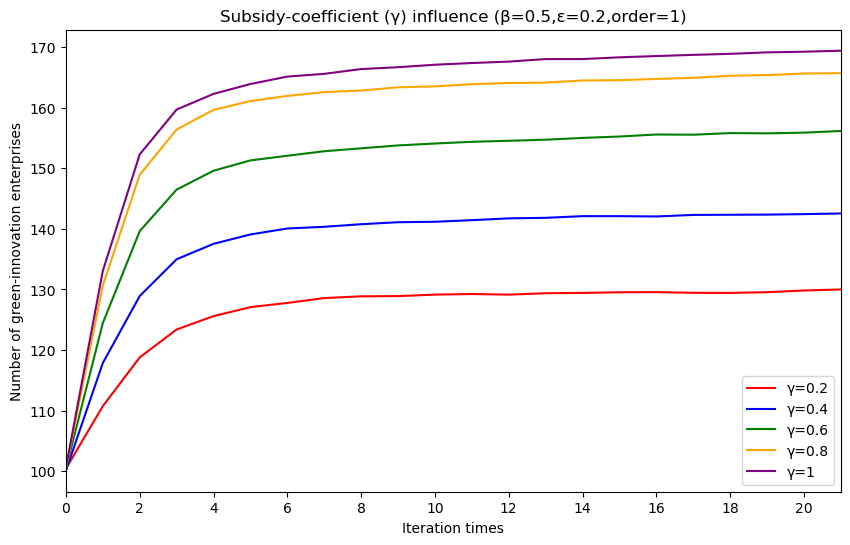

[100.425 110.745 118.79  123.395 125.605 127.085 127.78  128.58  128.87
 128.905 129.15  129.25  129.145 129.38  129.43  129.54  129.56  129.45
 129.43  129.555 129.83  130.005]
[100.095 117.86  128.915 134.985 137.53  139.075 140.06  140.34  140.765
 141.095 141.17  141.435 141.73  141.82  142.095 142.095 142.045 142.3
 142.325 142.35  142.43  142.54 ]
[100.44  124.445 139.62  146.475 149.59  151.29  152.065 152.805 153.29
 153.765 154.08  154.365 154.53  154.71  155.005 155.235 155.565 155.535
 155.8   155.76  155.87  156.15 ]
[100.52  130.63  148.925 156.39  159.63  161.085 161.935 162.56  162.82
 163.355 163.51  163.865 164.065 164.125 164.485 164.525 164.735 164.925
 165.255 165.37  165.625 165.69 ]
[100.62  133.055 152.285 159.685 162.265 163.9   165.12  165.575 166.365
 166.67  167.08  167.36  167.595 168.01  168.015 168.3   168.51  168.705
 168.875 169.12  169.225 169.39 ]


In [7]:
def run_simulation(run_times:int,rational_rate=9,iteration_times=5,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.1):
    results=[]
    for h in range(run_times):
        simulation=network_simulation(rational_rate=rational_rate,iteration_times=iteration_times,initial_rate=initial_rate,k=k,
                                        order=order,imitation_rate=imitation_rate,n=n,beta=beta,
                                        tax_coefficient=tax_coefficient,subsidy_coefficient=subsidy_coefficient)
        simulation.run()
        results.append(simulation.green_num_changelog)
        #if h<2:
        #    print(f"Result of run {h+1}:{simulation.green_num_changelog}")
        #elif h==2:
        #    print("...")
    return np.mean(results,axis=0)

simulation1 = run_simulation(200,rational_rate=9,iteration_times=22,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.2)
simulation2 = run_simulation(200,rational_rate=9,iteration_times=22,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.4)
simulation3 = run_simulation(200,rational_rate=9,iteration_times=22,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.6)
simulation4 = run_simulation(200,rational_rate=9,iteration_times=22,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.8)
simulation5 = run_simulation(200,rational_rate=9,iteration_times=22,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=1)
params = [
    [simulation1,'γ=0.2','red','-'],
    [simulation2,'γ=0.4','blue','-'],
    [simulation3,'γ=0.6','green','-'],
    [simulation4,'γ=0.8','orange','-'],
    [simulation5,'γ=1','purple','-'],

]
def plot(params):
    fig, ax = plt.subplots(figsize=(10, 6))
    for param in params:
        ax.plot(param[0], label=param[1],color=param[2],linestyle=param[3])
    ax.set_xlabel('Iteration times')
    ax.set_ylabel('Number of green-innovation enterprises')
    ax.set_title('Subsidy-coefficient (γ) influence (β=0.5,ε=0.2,order=1)')
    ax.legend()
    plt.xticks(np.arange(0, 21, 2))
    plt.xlim(0, 21)
    plt.show()
plot(params)
print(simulation1)
print(simulation2)
print(simulation3)
print(simulation4)
print(simulation5)
#plt.savefig("3.7_1.png",dpi=1200)

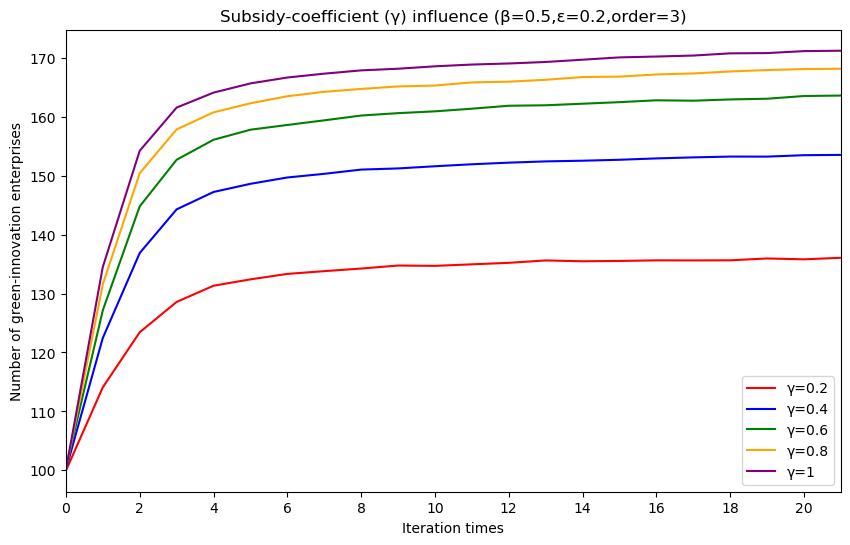

[ 99.94  114.095 123.43  128.575 131.325 132.405 133.33  133.8   134.24
 134.75  134.695 134.955 135.21  135.615 135.475 135.53  135.63  135.62
 135.64  135.95  135.805 136.065]
[100.135 122.465 136.875 144.28  147.23  148.615 149.69  150.31  151.03
 151.225 151.595 151.93  152.205 152.42  152.535 152.695 152.925 153.1
 153.235 153.23  153.47  153.52 ]
[100.395 127.155 144.79  152.695 156.09  157.795 158.6   159.385 160.2
 160.605 160.91  161.36  161.86  161.94  162.205 162.47  162.785 162.715
 162.93  163.05  163.51  163.59 ]
[100.13  131.565 150.41  157.845 160.74  162.275 163.47  164.225 164.71
 165.135 165.285 165.825 165.94  166.265 166.73  166.805 167.17  167.34
 167.675 167.915 168.08  168.135]
[100.08  134.51  154.22  161.55  164.085 165.65  166.65  167.305 167.86
 168.14  168.55  168.85  169.03  169.285 169.67  170.065 170.21  170.375
 170.75  170.795 171.13  171.195]


In [8]:
def run_simulation(run_times:int,rational_rate=9,iteration_times=5,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.1):
    results=[]
    for h in range(run_times):
        simulation=network_simulation(rational_rate=rational_rate,iteration_times=iteration_times,initial_rate=initial_rate,k=k,
                                        order=order,imitation_rate=imitation_rate,n=n,beta=beta,
                                        tax_coefficient=tax_coefficient,subsidy_coefficient=subsidy_coefficient)
        simulation.run()
        results.append(simulation.green_num_changelog)
        #if h<2:
        #    print(f"Result of run {h+1}:{simulation.green_num_changelog}")
        #elif h==2:
        #    print("...")
    return np.mean(results,axis=0)

simulation1 = run_simulation(200,rational_rate=9,iteration_times=22,initial_rate=0.5,k=0.1,
                                        order=3,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.2)
simulation2 = run_simulation(200,rational_rate=9,iteration_times=22,initial_rate=0.5,k=0.1,
                                        order=3,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.4)
simulation3 = run_simulation(200,rational_rate=9,iteration_times=22,initial_rate=0.5,k=0.1,
                                        order=3,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.6)
simulation4 = run_simulation(200,rational_rate=9,iteration_times=22,initial_rate=0.5,k=0.1,
                                        order=3,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.8)
simulation5 = run_simulation(200,rational_rate=9,iteration_times=22,initial_rate=0.5,k=0.1,
                                        order=3,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=1)

params = [
    [simulation1,'γ=0.2','red','-'],
    [simulation2,'γ=0.4','blue','-'],
    [simulation3,'γ=0.6','green','-'],
    [simulation4,'γ=0.8','orange','-'],
    [simulation5,'γ=1','purple','-'],

]
def plot(params):
    fig, ax = plt.subplots(figsize=(10, 6))
    for param in params:
        ax.plot(param[0], label=param[1],color=param[2],linestyle=param[3])
    ax.set_xlabel('Iteration times')
    ax.set_ylabel('Number of green-innovation enterprises')
    ax.set_title('Subsidy-coefficient (γ) influence (β=0.5,ε=0.2,order=3)') 
    ax.legend()
    plt.xticks(np.arange(0, 21, 2))
    plt.xlim(0, 21)
    plt.show()
plot(params)
print(simulation1)
print(simulation2)
print(simulation3)
print(simulation4)
print(simulation5)
#plt.savefig("3.7_1.png",dpi=1200)

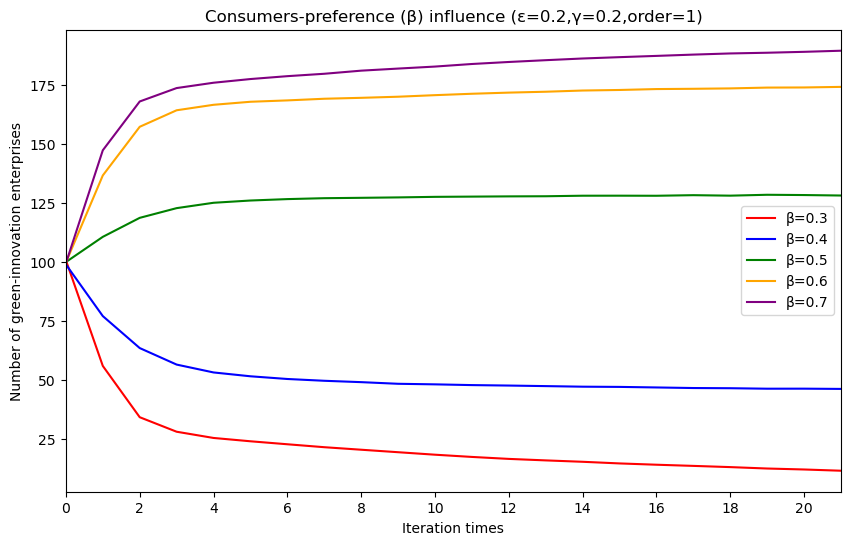

[100.805  55.98   34.235  28.08   25.44   24.03   22.765  21.52   20.45
  19.395  18.34   17.395  16.56   15.925  15.335  14.64   14.09   13.595
  13.08   12.48   12.07   11.545]
[99.015 77.115 63.56  56.555 53.22  51.59  50.445 49.685 49.105 48.41
 48.17  47.855 47.66  47.425 47.18  47.09  46.855 46.61  46.53  46.325
 46.34  46.235]
[100.03  110.72  118.775 122.89  125.165 126.125 126.725 127.11  127.27
 127.445 127.68  127.78  127.88  127.935 128.16  128.175 128.14  128.39
 128.185 128.56  128.445 128.245]
[ 99.84  136.765 157.385 164.39  166.715 168.    168.58  169.28  169.67
 170.14  170.8   171.395 171.88  172.255 172.765 173.    173.385 173.5
 173.665 174.01  174.065 174.31 ]
[ 99.525 147.43  168.12  173.81  176.07  177.635 178.855 179.87  181.19
 182.075 182.925 184.015 184.87  185.63  186.35  186.915 187.45  188.
 188.49  188.79  189.175 189.645]


In [9]:
def run_simulation(run_times:int,rational_rate=9,iteration_times=5,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.1):
    results=[]
    for h in range(run_times):
        simulation=network_simulation(rational_rate=rational_rate,iteration_times=iteration_times,initial_rate=initial_rate,k=k,
                                        order=order,imitation_rate=imitation_rate,n=n,beta=beta,
                                        tax_coefficient=tax_coefficient,subsidy_coefficient=subsidy_coefficient)
        simulation.run()
        results.append(simulation.green_num_changelog)
        #if h<2:
        #    print(f"Result of run {h+1}:{simulation.green_num_changelog}")
        #elif h==2:
        #    print("...")
    return np.mean(results,axis=0)

simulation1 = run_simulation(200,rational_rate=9,iteration_times=22,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=6,beta=0.3,
                                        tax_coefficient=0.2,subsidy_coefficient=0.2)
simulation2 = run_simulation(200,rational_rate=9,iteration_times=22,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=6,beta=0.4,
                                        tax_coefficient=0.2,subsidy_coefficient=0.2)
simulation3 = run_simulation(200,rational_rate=9,iteration_times=22,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.2)
simulation4 = run_simulation(200,rational_rate=9,iteration_times=22,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=6,beta=0.6,
                                        tax_coefficient=0.2,subsidy_coefficient=0.2)
simulation5 = run_simulation(200,rational_rate=9,iteration_times=22,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=6,beta=0.7,
                                        tax_coefficient=0.2,subsidy_coefficient=0.2)

params = [
    [simulation1,'β=0.3','red','-'],
    [simulation2,'β=0.4','blue','-'],
    [simulation3,'β=0.5','green','-'],
    [simulation4,'β=0.6','orange','-'],
    [simulation5,'β=0.7','purple','-'],

]
def plot(params):
    fig, ax = plt.subplots(figsize=(10, 6))
    for param in params:
        ax.plot(param[0], label=param[1],color=param[2],linestyle=param[3])
    ax.set_xlabel('Iteration times')
    ax.set_ylabel('Number of green-innovation enterprises')
    ax.set_title('Consumers-preference (β) influence (ε=0.2,γ=0.2,order=1)')
    ax.legend()
    plt.xticks(np.arange(0, 21, 2))
    plt.xlim(0, 21)
    plt.show()
plot(params)
print(simulation1)
print(simulation2)
print(simulation3)
print(simulation4)
print(simulation5)
#plt.savefig("3.7_1.png",dpi=1200)

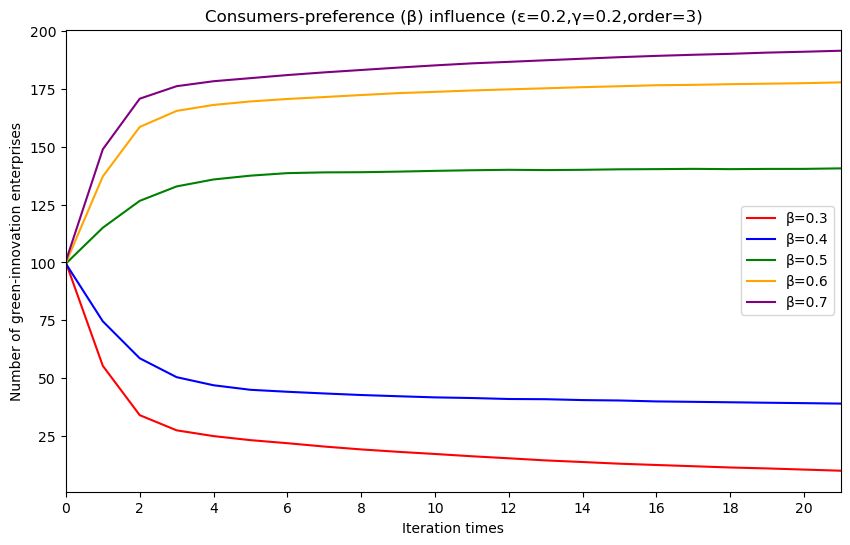

[99.98  55.33  34.025 27.465 24.97  23.225 21.905 20.46  19.22  18.185
 17.25  16.26  15.385 14.47  13.775 13.05  12.495 11.955 11.415 11.005
 10.51  10.015]
[99.435 74.56  58.595 50.43  46.935 44.975 44.125 43.395 42.72  42.195
 41.7   41.42  41.    40.91  40.53  40.355 39.955 39.775 39.585 39.385
 39.21  39.01 ]
[ 99.515 114.985 126.595 132.835 135.835 137.485 138.575 138.9   138.97
 139.22  139.555 139.82  140.015 139.89  140.01  140.225 140.305 140.42
 140.3   140.395 140.41  140.63 ]
[ 99.845 137.15  158.515 165.46  168.035 169.55  170.605 171.445 172.31
 173.135 173.68  174.285 174.765 175.22  175.71  176.11  176.55  176.705
 177.005 177.215 177.435 177.785]
[100.63  148.87  170.73  176.13  178.275 179.605 180.94  182.1   183.13
 184.165 185.12  185.995 186.65  187.33  188.005 188.665 189.23  189.705
 190.11  190.64  191.015 191.455]


In [10]:
def run_simulation(run_times:int,rational_rate=9,iteration_times=5,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.1):
    results=[]
    for h in range(run_times):
        simulation=network_simulation(rational_rate=rational_rate,iteration_times=iteration_times,initial_rate=initial_rate,k=k,
                                        order=order,imitation_rate=imitation_rate,n=n,beta=beta,
                                        tax_coefficient=tax_coefficient,subsidy_coefficient=subsidy_coefficient)
        simulation.run()
        results.append(simulation.green_num_changelog)
        #if h<2:
        #    print(f"Result of run {h+1}:{simulation.green_num_changelog}")
        #elif h==2:
        #    print("...")
    return np.mean(results,axis=0)

simulation1 = run_simulation(200,rational_rate=9,iteration_times=22,initial_rate=0.5,k=0.1,
                                        order=3,imitation_rate=0.1,n=6,beta=0.3,
                                        tax_coefficient=0.2,subsidy_coefficient=0.2)
simulation2 = run_simulation(200,rational_rate=9,iteration_times=22,initial_rate=0.5,k=0.1,
                                        order=3,imitation_rate=0.1,n=6,beta=0.4,
                                        tax_coefficient=0.2,subsidy_coefficient=0.2)
simulation3 = run_simulation(200,rational_rate=9,iteration_times=22,initial_rate=0.5,k=0.1,
                                        order=3,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.2)
simulation4 = run_simulation(200,rational_rate=9,iteration_times=22,initial_rate=0.5,k=0.1,
                                        order=3,imitation_rate=0.1,n=6,beta=0.6,
                                        tax_coefficient=0.2,subsidy_coefficient=0.2)
simulation5 = run_simulation(200,rational_rate=9,iteration_times=22,initial_rate=0.5,k=0.1,
                                        order=3,imitation_rate=0.1,n=6,beta=0.7,
                                        tax_coefficient=0.2,subsidy_coefficient=0.2)

params = [
    [simulation1,'β=0.3','red','-'],
    [simulation2,'β=0.4','blue','-'],
    [simulation3,'β=0.5','green','-'],
    [simulation4,'β=0.6','orange','-'],
    [simulation5,'β=0.7','purple','-'],

]
def plot(params):
    fig, ax = plt.subplots(figsize=(10, 6))
    for param in params:
        ax.plot(param[0], label=param[1],color=param[2],linestyle=param[3])
    ax.set_xlabel('Iteration times')
    ax.set_ylabel('Number of green-innovation enterprises')
    ax.set_title('Consumers-preference (β) influence (ε=0.2,γ=0.2,order=3)')
    ax.legend()
    plt.xticks(np.arange(0, 21, 2))
    plt.xlim(0, 21)
    plt.show()
plot(params)
print(simulation1)
print(simulation2)
print(simulation3)
print(simulation4)
print(simulation5)
#plt.savefig("3.7_1.png",dpi=1200)